<a href="https://colab.research.google.com/github/diogo0030/computer-vision-classification-of-defects-in-photovoltaic-modules/blob/main/classification_of_defects_in_photovoltaic_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identification**

* **Name:** Afonso Tomás de Magalhães Mateus
* **Student Number:** 202204126

* **Name:** Diogo Soares de Albergaria Oliveira
* **Student Number:** 202108325
---

# **Initial setup**

In [20]:
# Ver informação básica da GPU
!nvidia-smi
# Clonar o repo do dataset
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git

%cd InfraredSolarModules

!unzip 2020-02-14_InfraredSolarModules.zip


Wed Dec  3 20:27:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### **Library Imports**

In [21]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###Dataset Loading and Initial Exploration
In this section we load and perform an initial exploration of the Infrared Solar Modules dataset provided by Raptor Maps. The dataset consists of infrared (IR) images of photovoltaic (PV) modules, each annotated with a single anomaly type. The annotation file module_metadata.json contains, for every sample, the relative image path (images/<id>.jpg) and the corresponding anomaly_class. We parse this JSON file into a Pandas DataFrame and add an absolute-path column to facilitate subsequent image loading and preprocessing.

In [22]:
data_dir = Path('/content/InfraredSolarModules/InfraredSolarModules')
meta_path = data_dir / 'module_metadata.json'

# Ler o JSON
with open(meta_path, 'r') as f:
    metadata = json.load(f)

# Convert the metadata dictionary to a DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

df = df.rename(columns={'image_filepath': 'rel_path', 'anomaly_class': 'label'})

# Criar coluna com o caminho absoluto (Path)
df['path'] = df['rel_path'].apply(lambda p: data_dir / p)

df.head()

,rel_path,label,path
13357,images/13357.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
13356,images/13356.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
19719,images/19719.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
11542,images/11542.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...
11543,images/11543.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...


###Pre-Processing
Before training our models, we apply a sharpening step to the original infrared images. The Infrared Solar Modules dataset consists of very low–resolution images (24×40 pixels), where defects such as hot-spots or cell cracking often appear as small, low-contrast structures. To enhance these structures, we use an unsharp mask filter, implemented via the PIL.ImageFilter.UnsharpMask function with radius = 2 and strength = 150%.

The unsharp mask computes a blurred version of the image, subtracts it from the original to obtain an “edge image”, and then adds a scaled version of these edges back to the original. Qualitatively, this increases the contrast of cell boundaries and defect regions, as illustrated in Figure (Effect of Unsharp Mask Preprocessing on IR Images).



In [23]:


def apply_unsharp(image, radius=2, percent=150, threshold=0):
    """
    Aplica o filtro UnsharpMask à imagem.
    radius   : raio do blur usado para extrair bordas (2 píxeis, como no artigo)
    percent  : força com que as bordas são somadas de volta (150%)
    threshold: ignora pequenas diferenças (0 = tudo conta)
    """
    return image.filter(ImageFilter.UnsharpMask(radius=radius,
                                               percent=percent,
                                               threshold=threshold))


/tmp/ipython-input-4215751933.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(1, random_state=42))


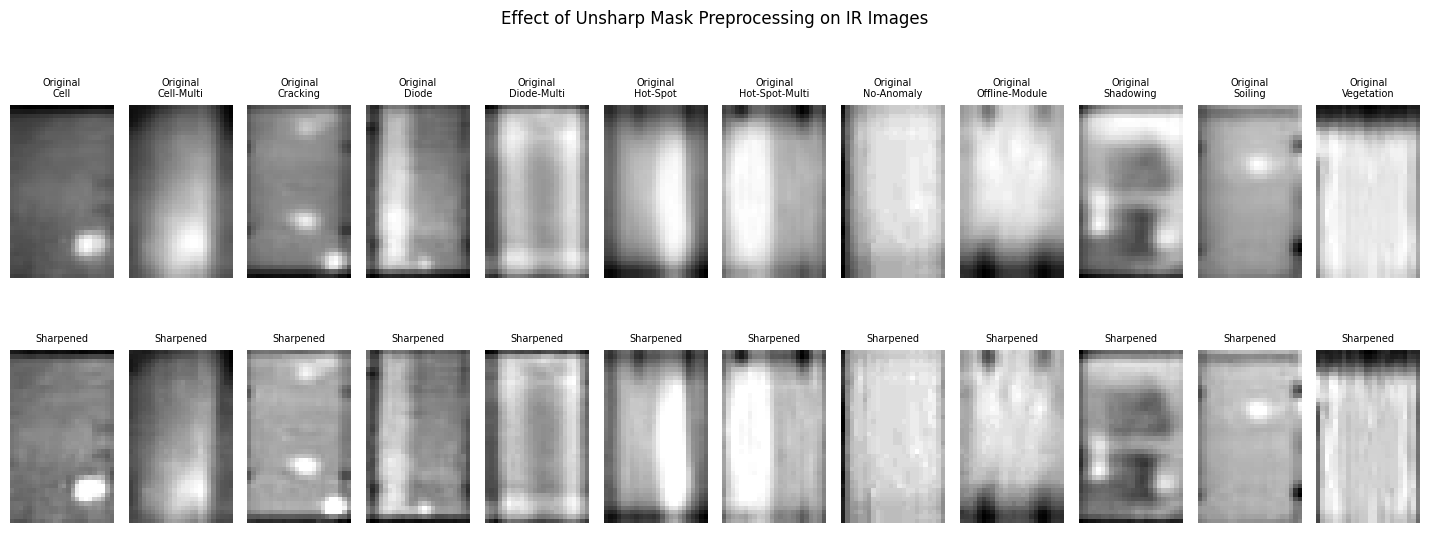

In [24]:
sample_df = (
    df.groupby('label', group_keys=False)
      .apply(lambda g: g.sample(1, random_state=42))
      .sort_values('label')            # opcional: ordena pelas classes
      .reset_index(drop=True)
)

num_samples = len(sample_df)

plt.figure(figsize=(1.2*num_samples, 6))

for i, (_, row) in enumerate(sample_df.iterrows()):
    img = Image.open(row['path'])
    sharp = apply_unsharp(img)

    # Linha 1: original
    plt.subplot(2, len(sample_df), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{row['label']}", fontsize=7)
    plt.axis('off')

    # Linha 2: filtrada
    plt.subplot(2, len(sample_df), i+1+len(sample_df))
    plt.imshow(sharp, cmap='gray')
    plt.title("Sharpened", fontsize=7)
    plt.axis('off')

plt.suptitle('Effect of Unsharp Mask Preprocessing on IR Images', fontsize=12)
plt.tight_layout()
plt.show()

In [25]:
sharp_dir = data_dir / 'images_sharp'
sharp_dir.mkdir(exist_ok=True)

# Aplica o unsharp a TODAS as imagens e guarda em images_sharp/
for img_path in tqdm(df['path'], total=len(df)):
    img_path = Path(img_path)
    dst_path = sharp_dir / img_path.name  # mesmo nome, nova pasta

    # Se já existir, salta
    if dst_path.exists():
      continue

    img = Image.open(img_path)
    sharp = apply_unsharp(img)
    sharp.save(dst_path)

df['sharp_path'] = df['path'].apply(lambda p: sharp_dir / Path(p).name)
display(df)


100%|██████████| 20000/20000 [00:00<00:00, 38081.12it/s]


,rel_path,label,path,sharp_path
13357,images/13357.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
13356,images/13356.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
19719,images/19719.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
11542,images/11542.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
11543,images/11543.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
...,...,...,...,...
8488,images/8488.jpg,Vegetation,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
8489,images/8489.jpg,Vegetation,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
7464,images/7464.jpg,Cracking,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...
18065,images/18065.jpg,No-Anomaly,/content/InfraredSolarModules/InfraredSolarMod...,/content/InfraredSolarModules/InfraredSolarMod...


###Dividing Dataset
The dataset was split into training (80%), validation (10%) and test (10%) sets using stratified sampling to preserve the original class distribution. As shown in Table, the relative frequency of each anomaly class is nearly identical across the three splits

In [26]:
# Copiamos o df só por segurança
full_df = df.copy()

train_df, temp_df = train_test_split(
    full_df,
    test_size=0.2,
    stratify=full_df['label'],   # mantém proporção de classes
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42,
)

print(f"Train: {len(train_df)} samples")
print(f"Val:   {len(val_df)} samples")
print(f"Test:  {len(test_df)} samples")

#test_size=0.2 ficamos com um proporçao de 80/20
#depois dividimos os 20% em metade test_size=0.5
#stratify=... mantem a proporçao


def show_split_stats(name, split_df):
    print(f"\n{name} split ({len(split_df)} samples)")
    counts = split_df['label'].value_counts().sort_index()
    props  = counts / len(split_df) * 100  # percentagem

    stats_df = pd.DataFrame({
        'count': counts,
        'percent': props.round(2)
    })
    print(stats_df)

show_split_stats("Train", train_df)
show_split_stats("Val",   val_df)
show_split_stats("Test",  test_df)


Train: 16000 samples
Val:   2000 samples
Test:  2000 samples

Train split (16000 samples)
                count  percent
label                         
Cell             1502     9.39
Cell-Multi       1030     6.44
Cracking          752     4.70
Diode            1199     7.49
Diode-Multi       140     0.88
Hot-Spot          199     1.24
Hot-Spot-Multi    197     1.23
No-Anomaly       8000    50.00
Offline-Module    662     4.14
Shadowing         845     5.28
Soiling           163     1.02
Vegetation       1311     8.19

Val split (2000 samples)
                count  percent
label                         
Cell              188     9.40
Cell-Multi        129     6.45
Cracking           94     4.70
Diode             150     7.50
Diode-Multi        18     0.90
Hot-Spot           25     1.25
Hot-Spot-Multi     24     1.20
No-Anomaly       1000    50.00
Offline-Module     82     4.10
Shadowing         105     5.25
Soiling            21     1.05
Vegetation        164     8.20

Test split (200

###Data Augmentation

In [27]:
#aqui so duplicamos linhas do dataframe apenas

# Ver quantas imagens tem cada classe no train
train_counts = train_df['label'].value_counts().sort_index()
print("Original train counts:\n", train_counts)

max_count = train_counts.max()  # alvo: nº da classe maior (No-Anomaly = 8000)

balanced_parts = []

for label, count in train_counts.items():
    df_label = train_df[train_df['label'] == label]

    if count < max_count:
        # nº extra que precisamos para chegar ao max_count
        n_extra = max_count - count

        # sample com reposição das próprias imagens dessa classe
        extra = df_label.sample(n_extra, replace=True, random_state=42)

        df_balanced_label = pd.concat([df_label, extra], ignore_index=True)
    else:
        # classe já está no máximo (No-Anomaly)
        df_balanced_label = df_label

    balanced_parts.append(df_balanced_label)

# Junta tudo e baralha as linhas
train_balanced_df = pd.concat(balanced_parts, ignore_index=True)
train_balanced_df = train_balanced_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("\nBalanced train counts:\n", train_balanced_df['label'].value_counts().sort_index())
print("\nTotal balanced train samples:", len(train_balanced_df))


Original train counts:
 label
Cell              1502
Cell-Multi        1030
Cracking           752
Diode             1199
Diode-Multi        140
Hot-Spot           199
Hot-Spot-Multi     197
No-Anomaly        8000
Offline-Module     662
Shadowing          845
Soiling            163
Vegetation        1311
Name: count, dtype: int64

Balanced train counts:
 label
Cell              8000
Cell-Multi        8000
Cracking          8000
Diode             8000
Diode-Multi       8000
Hot-Spot          8000
Hot-Spot-Multi    8000
No-Anomaly        8000
Offline-Module    8000
Shadowing         8000
Soiling           8000
Vegetation        8000
Name: count, dtype: int64

Total balanced train samples: 96000


In [30]:


# Garantir que todos os path sao string em todos os splits
df['sharp_path'] = df['sharp_path'].astype(str)
train_df['sharp_path'] = train_df['sharp_path'].astype(str)
val_df['sharp_path'] = val_df['sharp_path'].astype(str)
test_df['sharp_path'] = test_df['sharp_path'].astype(str)
train_balanced_df['sharp_path'] = train_balanced_df['sharp_path'].astype(str)

# Só para confirmar:
#df[['sharp_path', 'label']].head()


BATCH_SIZE = 32
IMG_SIZE_SMALL = (40, 24)      # ou (24, 40) se as estivermos a ver deitadas
COLOR_MODE_SMALL = 'grayscale' # 1 canal (IR)
# IMG_SIZE_LARGE = (160, 160)
# COLOR_MODE_LARGE = 'rgb'

# === TRAIN: augmentation + normalização ===
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalização [0,1]
    rotation_range=10,       # rotações pequenas
    width_shift_range=0.1,   # translação até ~10% da largura
    height_shift_range=0.1,  # translação até ~10% da altura
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.7, 1.3),
    fill_mode='nearest'
)

# === VAL / TEST: só normalização (sem augmentation) ===
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# TRAIN generator com augmentation
train_gen_small = train_datagen.flow_from_dataframe(
    train_balanced_df,
    x_col='sharp_path',         # imagens com unsharp
    y_col='label',
    target_size=IMG_SIZE_SMALL,
    color_mode=COLOR_MODE_SMALL,
    class_mode='categorical',   # one-hot (para softmax)
    batch_size=BATCH_SIZE,
    shuffle=True
)

# VAL generator (sem augmentation)
val_gen_small = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='sharp_path',
    y_col='label',
    target_size=IMG_SIZE_SMALL,
    color_mode=COLOR_MODE_SMALL,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# TEST generator (sem augmentation)
test_gen_small = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='sharp_path',
    y_col='label',
    target_size=IMG_SIZE_SMALL,
    color_mode=COLOR_MODE_SMALL,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 96000 validated image filenames belonging to 12 classes.
Found 2000 validated image filenames belonging to 12 classes.
Found 2000 validated image filenames belonging to 12 classes.


###Pre-Check

Train samples (balanced): 96000
Val samples: 2000
Test samples: 2000

Class indices (label -> índice):
{'Cell': 0, 'Cell-Multi': 1, 'Cracking': 2, 'Diode': 3, 'Diode-Multi': 4, 'Hot-Spot': 5, 'Hot-Spot-Multi': 6, 'No-Anomaly': 7, 'Offline-Module': 8, 'Shadowing': 9, 'Soiling': 10, 'Vegetation': 11}
Batch X shape: (32, 40, 24, 1)
Batch y shape: (32, 12)
Pixel range: min = 0.0 , max = 1.0


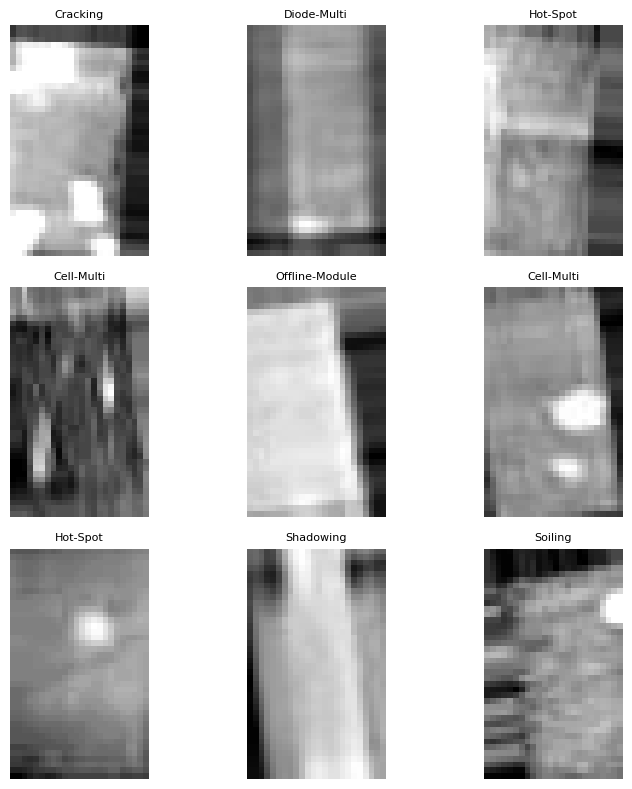

In [31]:
print("Train samples (balanced):", train_gen_small.samples)
print("Val samples:", val_gen_small.samples)
print("Test samples:", test_gen_small.samples)

print("\nClass indices (label -> índice):")
print(train_gen_small.class_indices)

bx, by = next(train_gen_small)

print("Batch X shape:", bx.shape)
print("Batch y shape:", by.shape)
print("Pixel range: min =", bx.min(), ", max =", bx.max())


# Pede um batch ao generator
bx, by = next(train_gen_small)

# Mapa índice -> nome da classe
inv_class_indices = {v: k for k, v in train_gen_small.class_indices.items()}

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)

    # tirar o último eixo (canal) para imshow em grayscale
    img = bx[i].squeeze()
    label_idx = np.argmax(by[i])
    label_name = inv_class_indices[label_idx]

    plt.imshow(img, cmap='gray')
    plt.title(label_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

